In [1]:
import src.utils as utils
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns

In [2]:
df = utils.build_color_spa_dataset('../data/plantvillage/plantvillage dataset')

## Análisis de enfermedades comunes entre especies

Realizaremos un análisis sobre enfermedades presentes en más de una especie para determinar si existen patrones que dificulten al modelo reconocer la misma enfermedad en diversas especies de plantas. O por el contrario, el modelo fácilmente podrá identificar una enfermedad independientemente de la hoja.

In [3]:
# Filtrar las filas donde haya alguna enfermedad (no sanas)
df_enfermas = df[df['Enfermedad'].notna() & (df['Enfermedad'].str.lower() != 'none') & (df['Enfermedad'] != 'Sano')]

# Agrupar por enfermedad y contar las especies únicas para cada una
enfermedades_por_especie = df_enfermas.groupby('Enfermedad')['Especie'].nunique()

# Filtrar aquellas enfermedades que aparecen en más de una especie
enfermedades_comunes = enfermedades_por_especie[enfermedades_por_especie > 1].reset_index()

print("Enfermedades que afectan a más de una especie de planta:")
print(enfermedades_comunes)


Enfermedades que afectan a más de una especie de planta:
                            Enfermedad  Especie
0                    Mancha bacteriana        3
1  Oídio (cenicilla o polvillo blanco)        2
2                    Podredumbre negra        2
3                         Tizón tardío        2
4                       Tizón temprano        2


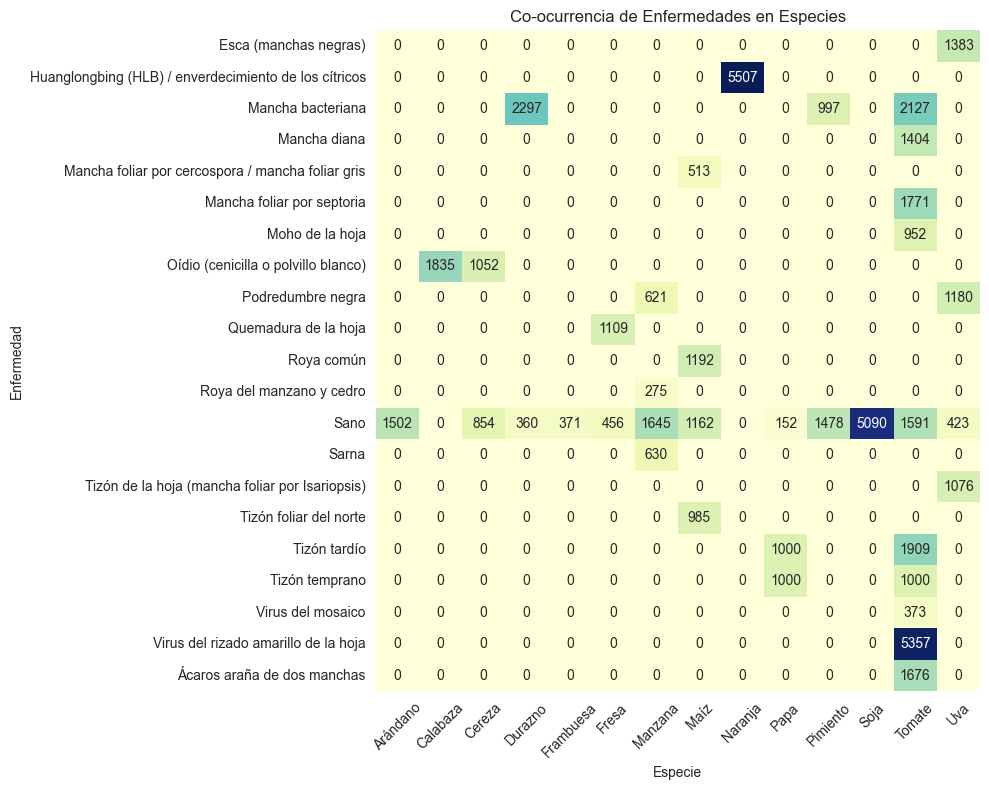

In [4]:
df_disease = df[df['Enfermedad'].notna()]

heatmap_data = pd.crosstab(df_disease['Enfermedad'], df_disease['Especie'])

heatmap_data = heatmap_data[heatmap_data.sum(axis=1) > 1]

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Co-ocurrencia de Enfermedades en Especies")
plt.xlabel("Especie")
plt.ylabel("Enfermedad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Vemos que solo hay 5 enfermedades presentes en más de una especie de planta. Utilizaremos la enfermedad Mancha bacteriana como un ejemplo para comparar hojas enfermedas entre especies

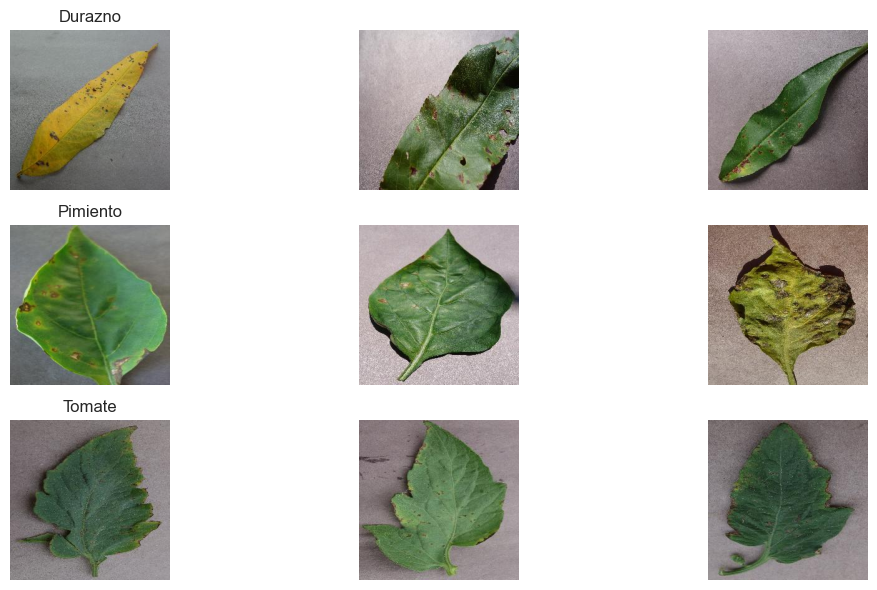

In [5]:
enfermedad = "Mancha bacteriana"
especies = ["Durazno", "Pimiento", "Tomate"]

bacterial_spot = df[(df['Enfermedad'] == enfermedad) & (df['Especie'].isin(especies))]

fig, axes = plt.subplots(len(especies), 3, figsize=(12, 6))

for i, especie in enumerate(especies):
    subset = bacterial_spot[bacterial_spot['Especie'] == especie]

    if subset.empty:
        for j in range(3):
            axes[i, j].axis('off')
        axes[i, 0].set_title(f"{especie} (sin datos)")
        continue

    sample_count = min(3, len(subset))
    sampled_rows = subset.sample(sample_count)

    for j in range(3):
        axes[i, j].axis('off')

        if j < sample_count:
            row = sampled_rows.iloc[j]
            img = Image.open(row['File'])
            axes[i, j].imshow(img)

    axes[i, 0].set_title(especie)

plt.tight_layout()
plt.show()

A simple vista parece haber signos comunes en la enfermedad a pesar de que las hojas son distintas

Para profundizar el análisis usaremos un modelo HOG para describir la forma y textura de objetos dentro de una imagen de la hoja de las plantas. Luego extraeremos los vectores de las características de cada imágen y las representaremos en un plano utilizando PSA y TSNE. Eso nos dará una idea gráfica de que tanta semejanza existe entre distintas especies con la misma enfermedad. 

Utilizamos HOG por ser un modelo computacionalmente ligero que no requiere entrenamiento. Nos pareció ideal para esta etapa exploratoria 

100%|██████████| 15018/15018 [00:55<00:00, 268.56it/s]


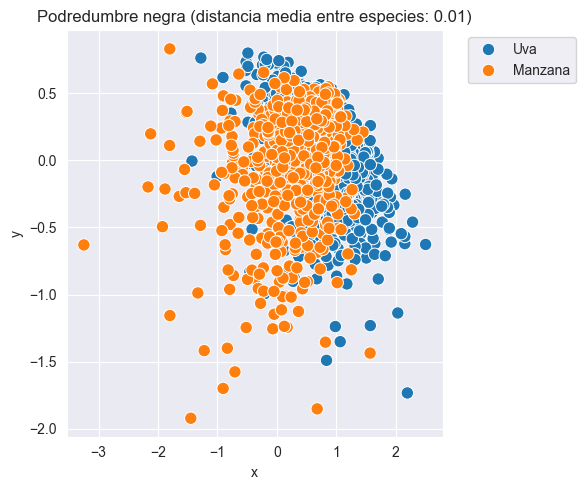

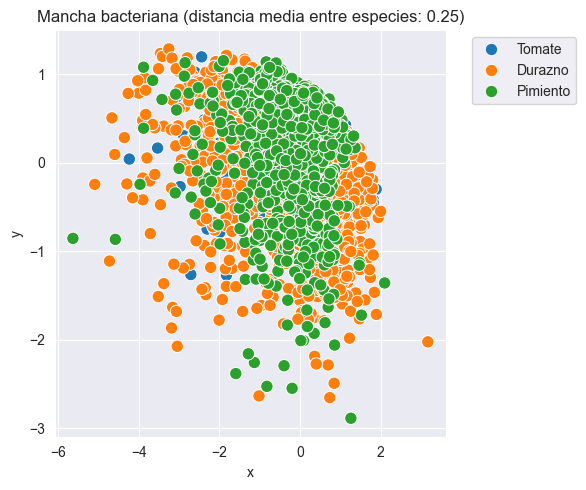

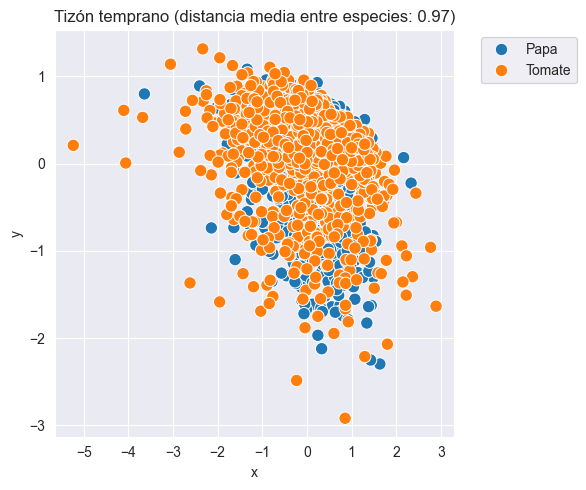

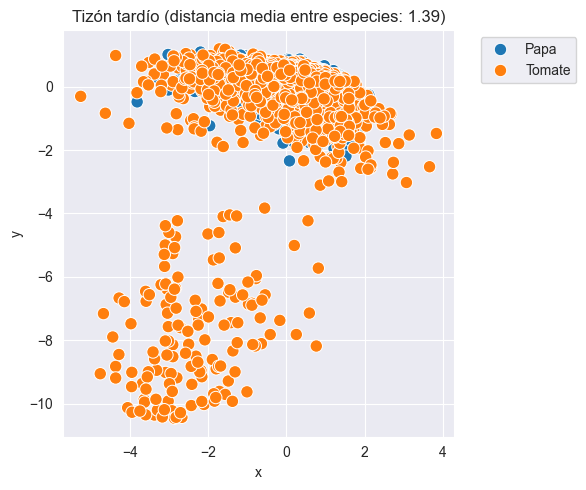

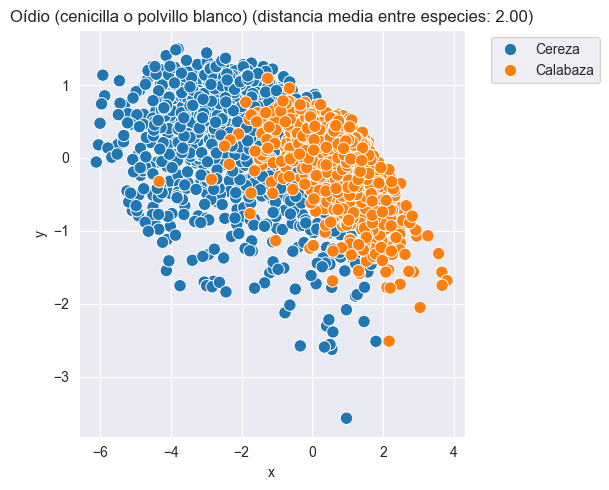

In [6]:
df_filtrado = df[df["Enfermedad"].isin(enfermedades_comunes['Enfermedad'])]
utils.plt_distance_species_with_same_disease_pca(df_filtrado)

100%|██████████| 15018/15018 [00:55<00:00, 272.01it/s]


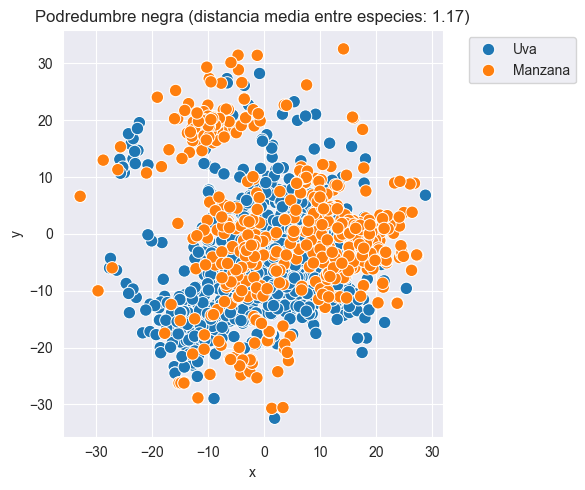

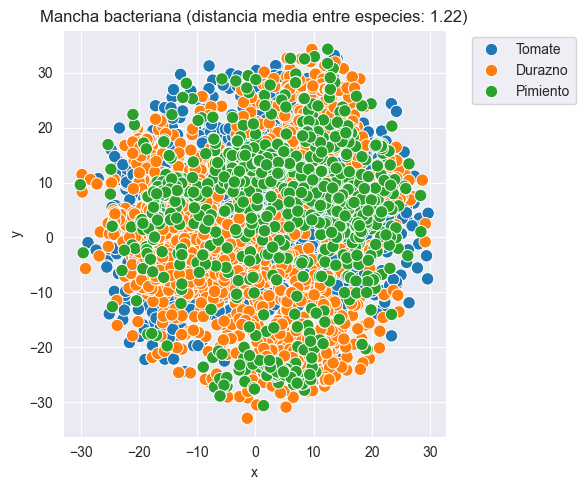

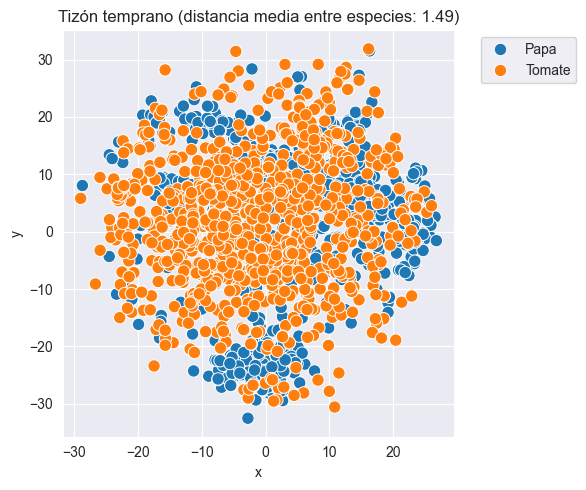

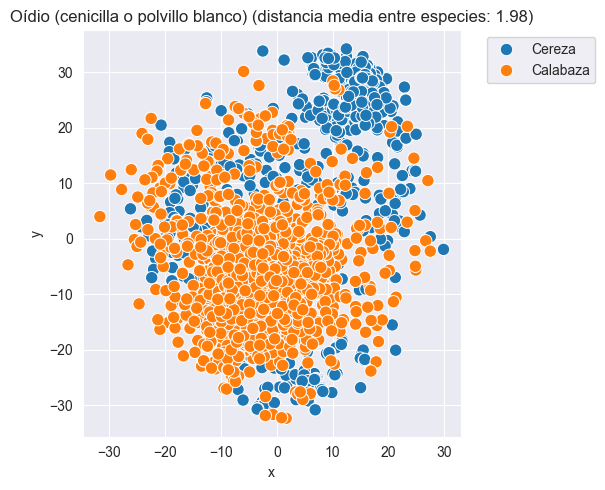

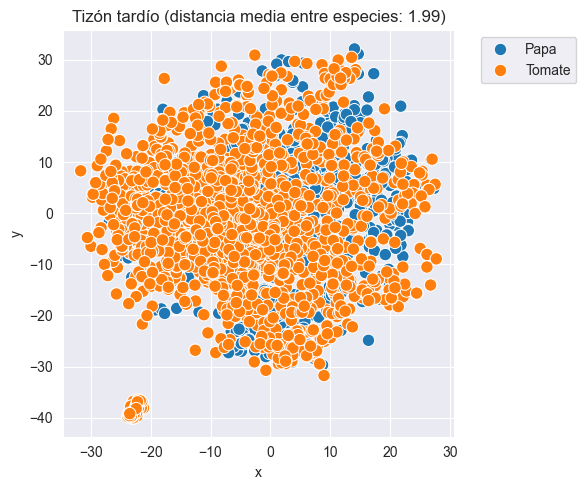

In [7]:
utils.plt_distance_species_with_same_disease_tsne(df_filtrado)

Haremos lo mismo con las hojas sanas entre especies para entender cuál es la semejanza entre las especies en su estado natural (o sano) para utilizarlo de parámetro de distancia cuando están enfermas. En este caso representaremos utilizando una matriz de confusión.

100%|██████████| 15084/15084 [00:56<00:00, 268.34it/s]


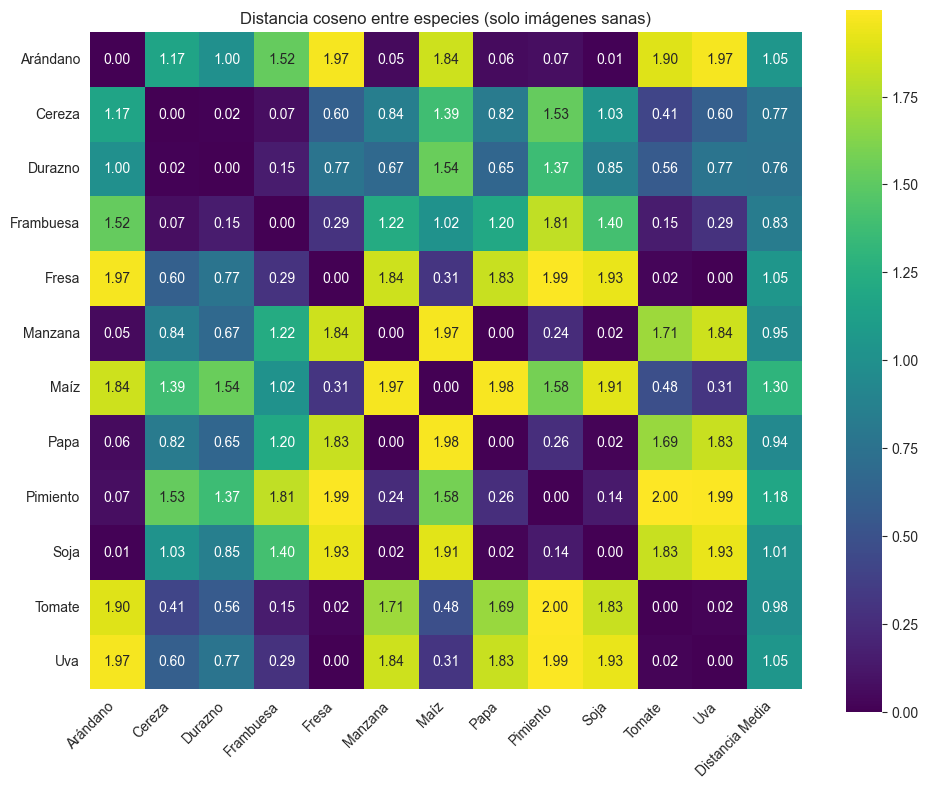

In [8]:
utils.plt_distance_healthy_species_pca(df)

100%|██████████| 15084/15084 [01:09<00:00, 218.01it/s]


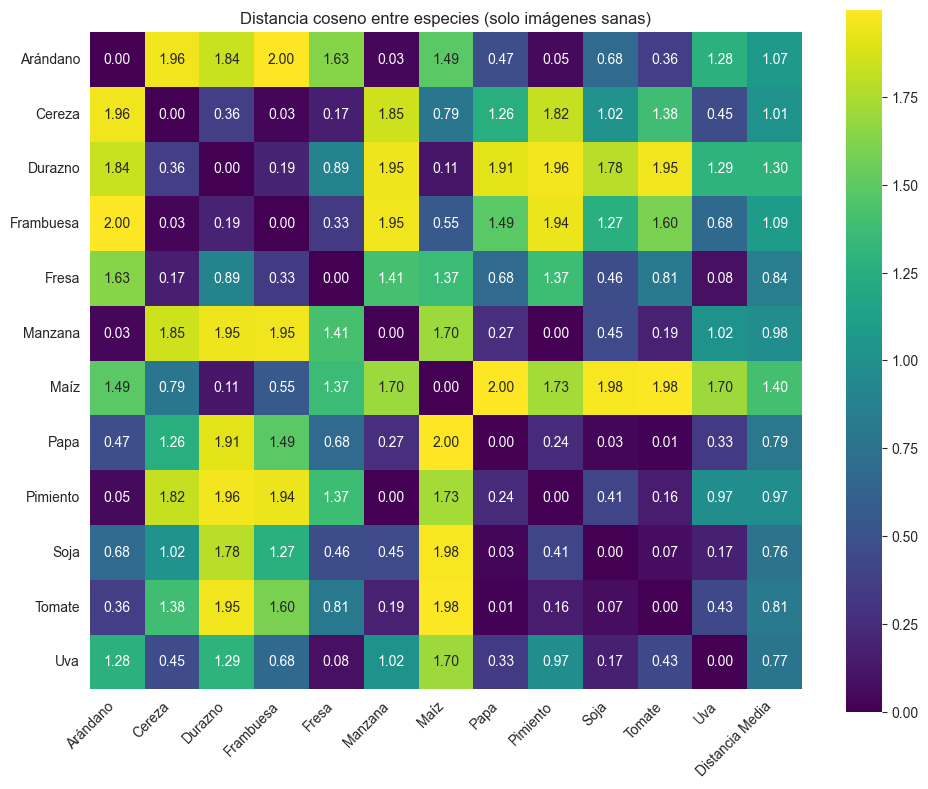

In [9]:
utils.plt_distance_healthy_species_tsne(df)

## Conclusiones – Análisis de enfermedades comunes entre especies

1. _Distancias pequeñas entre especies para una misma enfermedad_

En varios gráficos PCA de enfermedades, como Tizón temprano o Mancha bacteriana, se observa una alta superposición entre las especies afectadas. Las distancias promedio (medidas con similitud coseno) entre especies son bajas, con valores de 0.25 y 0.97 respectivamente.

Esta misma tendencia se refleja en los gráficos TSNE, donde la distancia promedio entre plantas es mayor debido a que la nube de puntos es más dispersa. Sin embargo, los puntos correspondientes a cada especie siguen agrupados muy cerca entre sí. Esto indica que las diferencias entre las características de las hojas dentro de una misma especie pueden ser mayores que las diferencias entre distintas especies que presentan la misma enfermedad.

Un caso particular es el de Tizón tardío, donde se observa un grupo de puntos separado del resto de la nube que incluye ambas especies. Esto sugiere que hay un conjunto de imágenes con características atípicas, incluso dentro de la misma especie, lo que podría indicar que el modelo podría tener dificultades para reconocer plantas de tomate como pertenecientes a una misma especie en todos los casos.

La ausencia de grupos claramente diferenciados sugiere que la enfermedad genera efectos visuales similares en las hojas, independientemente de la especie. En cuanto a las características extraídas, los patrones resultan bastante semejantes.

2. _Distancias entre especies sanas_

Al analizar la matriz de distancias entre imágenes de plantas sanas, se encuentran diferencias entre los resultados de PCA y TSNE. Por ejemplo, en TSNE, la similitud coseno entre papa y tomate es mucho menor que en PCA, donde sí se observa una diferencia más marcada.

Esta diferencia podría indicar que el modelo tiene dificultad para distinguir plantas de la misma especie dependiendo de la imagen específica que se analice.

Además, no se observan diferencias significativas entre las distancias de plantas sanas y enfermas. Esto permite concluir que la enfermedad no altera tanto la forma de las hojas como para hacer que las plantas se parezcan más entre ellas.

3. _Enfermedades con grandes distancias entre especies_

El Oídio presenta la mayor distancia entre especies, lo cual se evidencia claramente en el PCA, donde los centros de las nubes de puntos para cada especie están muy alejados.

Sin embargo, no es posible determinar si esta distancia se amplía o reduce cuando las plantas están enfermas, ya que no contamos con ejemplos de hojas sanas de calabaza para comparar.

En términos generales, varias enfermedades comunes tienden a manifestarse visualmente de manera similar entre diferentes especies, al menos desde la perspectiva de las características (features) que se están utilizando para el análisis.